### Question:
* When there is noise added to logits before computing ppls (without affecting brainbench acc), is there correlation between the change in ppl and the original ppl of the item.

### Motivation:
* This investigation is to answer the question in the main experiment whether fwd-rev-ppl-diff need normalized by the mean of fwd and rev ppl-diff. As we saw, blindly normalizing erases significant correlation between fwd-rev-ppl-diff and correctness.
* This investigation serves to immitate the situation where for each item, we have fwd-ppl and rev-ppl and they differ by some amount. Here, we add noise to logits to cause change in ppls.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def _ppl_original_ppl_altered_and_ppl_diff(PPL_A_and_B, labels, norm=False):
    """
    Args:
        PPL_A_and_B: (N, 2) array of PPL values for A and B
        labels: (N, ) array of labels (0 or 1) where 0 indicates A correct, B incorrect
        norm: normalization method for PPL difference
            False (default): no normalization
            True: normalize by the PPL of the original

    Returns:
        PPL_original: (N, ) array of PPL values of original/correct options
        PPL_altered: (N, ) array of PPL values of altered/incorrect options
        PPL_diff: (N, ) array of PPL difference between altered and original options
    """
    PPL_A = PPL_A_and_B[:, 0]
    PPL_B = PPL_A_and_B[:, 1]
    PPL_original = []
    PPL_altered = []
    PPL_diff = []  # altered - original
    for i, label in enumerate(labels):
        if label == 0:  # A correct, B incorrect
            PPL_original.append(PPL_A[i])
            PPL_altered.append(PPL_B[i])
            diff = PPL_B[i] - PPL_A[i]
            if norm is True:
                diff /= PPL_A[i]
            PPL_diff.append(diff)
        else:
            PPL_original.append(PPL_B[i])
            PPL_altered.append(PPL_A[i])
            diff = PPL_A[i] - PPL_B[i]
            if norm is True:
                diff /= PPL_B[i]
            PPL_diff.append(diff)
    return np.array(PPL_original), np.array(PPL_altered), np.array(PPL_diff)

def _per_item_correctness(PPL_A_and_B, labels):
    """
    Args:
        PPL_A_and_B: (N, 2) array of PPL values for A and B
        labels: (N, ) array of labels (0 or 1) where 0 indicates A correct, B incorrect

    Returns:
        correctness: (N, ) array of correctness values (1 if correct, 0 if incorrect)
    """
    correctness = []
    PPL_A = PPL_A_and_B[:, 0]
    PPL_B = PPL_A_and_B[:, 1]
    for i, label in enumerate(labels):
        if label == 0:  # A correct, B incorrect
            correctness.append(1 if PPL_A[i] < PPL_B[i] else 0)
        else:
            correctness.append(1 if PPL_B[i] < PPL_A[i] else 0)
    return np.array(correctness)

In [ ]:
# Bayes fwd models
fwd_bayes_brainbench_ppls_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_fwd/human_abstracts/PPL_A_and_B.npy"
fwd_bayes_brainbench_labels_path = "model_results/gpt2_scratch_neuro_tokenizer_bayes_fwd/human_abstracts/labels.npy"

fwd_bayes_brainbench_ppls = np.load(fwd_bayes_brainbench_ppls_path)
fwd_bayes_brainbench_labels = np.load(fwd_bayes_brainbench_labels_path)

fwd_bayes_brainbench_ppls_original, fwd_bayes_brainbench_ppls_altered, fwd_bayes_brainbench_ppls_diff \
    = _ppl_original_ppl_altered_and_ppl_diff(fwd_bayes_brainbench_ppls, fwd_bayes_brainbench_labels)

# Bayes fwd models with noise
# noise = 1e-5
# noise = 0.001
noise = 0.01
random_seed = 42
fwd_bayes_brainbench_ppls_with_noise_path = f"model_results/gpt2_scratch_neuro_tokenizer_bayes_fwd/human_abstracts/PPL_A_and_B_noise_{noise}_seed_{random_seed}.npy"

fwd_bayes_brainbench_ppls_with_noise = np.load(fwd_bayes_brainbench_ppls_with_noise_path)

fwd_bayes_brainbench_ppls_with_noise_original, fwd_bayes_brainbench_ppls_with_noise_altered, \
    fwd_bayes_brainbench_ppls_with_noise_diff \
    = _ppl_original_ppl_altered_and_ppl_diff(fwd_bayes_brainbench_ppls_with_noise, fwd_bayes_brainbench_labels)

In [18]:
for i in range(len(fwd_bayes_brainbench_ppls_with_noise_original)):
    original = fwd_bayes_brainbench_ppls_original[i]
    original_with_noise = fwd_bayes_brainbench_ppls_with_noise_original[i]
    print(original, original_with_noise)

69.05635330929263 69.05306052427258
31.478891713348123 31.48132347672429
39.81797894117577 39.79220335986666
83.54349173400514 83.5350467929285
57.64704178473034 57.639263134388685
41.23941382996342 41.235028882971584
56.96106334358797 56.95755966279536
52.05037997677833 52.056237721412685
25.838715554396437 25.850262779369405
67.91937387500914 67.94697276286833
32.87635624097675 32.891479865016905
62.08105419307041 62.04731645277983
73.39347374840486 73.3874195628884
79.62859153827937 79.65722596847478
75.75725374092488 75.77022332160682
38.485853323090154 38.461242678328574
64.58976819695421 64.58625722900936
82.54951258269271 82.53459547683097
50.04624191384092 50.048783484552686
34.677806534643004 34.67559082609084
78.65384491776716 78.69383549157985
91.47747592759214 91.50661863497203
49.00378009625581 49.03372214062375
78.57553582304992 78.58613990758082
68.87295427692027 68.87554877930735
34.964139760978384 34.97506175819715
91.99061435413994 91.99912446912117
31.126782689555608

### Analysis: how much has ppl changed after noise added.

<Axes: ylabel='Count'>

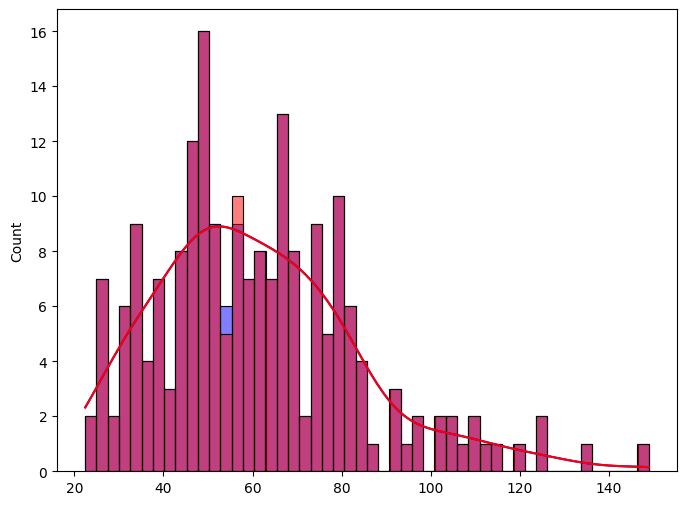

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(fwd_bayes_brainbench_ppls_original, bins=50, color='blue', label='PPL original', ax=ax, kde=True)
sns.histplot(fwd_bayes_brainbench_ppls_with_noise_original, bins=50, color='red', label='PPL original with noise', ax=ax, kde=True)

### Analysis: correlation between ppl changed and original ppls.